In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np

# Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.image as mplimg
from matplotlib.colors import DivergingNorm, LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from cycler import cycler
from matplotlib.patches import Rectangle

# ML
from soap import compute_soap_density, reshape_soaps
from soap import rrw_neighbors, make_tuples
from soap import extract_species_pair_groups
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Utilities
import h5py
import json
import re
import project_utils as utils
from tools import load_json

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Functions

In [37]:
#def make_plot(output, density, r_grid, p_grid, species_pair_label, neighbors=None):
# TODO: scatter points only for selected environments?
def make_plot(output, r_grid, p_grid, density, density_highlight=None,
              rrw_neighbors=None, idxs_neighbors=None, 
              species_pair_idx=None, species_pair_name=None,
              scatter=False, annotate=[]):
    
    # Camera view settings
    x = -1.25
    y = -1.25
    z = 1.25

    # Compute aspect ratio from data
    # so we can set it manually including zoom
    # TODO: make this compatible with differing r_grid and p_grid sizes
    zoom = 1.0
    aspect_ratio_keys = ['x', 'y', 'z']
    xyz_max = np.amax(np.column_stack((r_grid, r_grid, p_grid)), axis=0)
    xyz_min = np.amin(np.column_stack((r_grid, r_grid, p_grid)), axis=0)
    xyz_ratios = np.abs(xyz_max - xyz_min)
    xyz_ratios = xyz_ratios / xyz_ratios[0] * zoom
    xyz_ratios[2] *= xyz_ratios[0] / xyz_ratios[2] # Make cube

    aspect_ratio = {key: value for key, value in zip(aspect_ratio_keys, xyz_ratios)}
    
    annotations = []
    
    # Plot
    rx_grid, ry_grid, pz_grid = np.meshgrid(r_grid, r_grid, p_grid, indexing='ij')
    
    avg = np.mean(density)
    std = np.std(density)
    
    avg_highlight = np.mean(density_highlight)
    std_highlight = np.std(density_highlight)

    fig = go.Figure()
    fig.add_trace(
        go.Isosurface(
            x=rx_grid.flatten(),
            y=ry_grid.flatten(),
            z=pz_grid.flatten(),
            value=density.flatten(),
            coloraxis='coloraxis1',
            isomin=avg - 2.0*std,
            isomax=avg + 2.0*std,
            opacity=0.3,
            surface_count=4,
            caps=dict(x_show=False, y_show=False, z_show=False)
        )
    )
        
    if density_highlight is not None:
        fig.add_trace(
            go.Volume(
                x=rx_grid.flatten(),
                y=ry_grid.flatten(),
                z=pz_grid.flatten(),
                value=density_highlight.flatten(),
                coloraxis='coloraxis2',
                isomin=avg_highlight - 2.0*std_highlight,
                isomax=avg_highlight + 2.0*std_highlight,
                opacity=0.4,
                surface_count=2,
                caps=dict(x_show=False, y_show=False, z_show=False)
            )
        )

    if rrw_neighbors is not None and species_pair_idx is not None:
        atom_stencils = [[], [], []]
        for xyz in range(0, len(atom_stencils)):
            atom_stencils[xyz] = np.concatenate(
                [center[species_pair_idx][xyz].flatten() for center in rrw_neighbors]
            )

        if idxs_neighbors is not None:
            idxs = [[], [], []]
            for xyz in range(0, len(idxs)):
                idxs[xyz] = np.concatenate(
                    [center[species_pair_idx][xyz].flatten() for center in idxs_neighbors]
                )
            hovertemplate = 'x: %{x}<br>y: %{y}<br>z: %{z}<br>(i, j, k): %{text}'
            hovertext = ['{}'.format(i) for i in zip(idxs[0], idxs[1], idxs[2])]
        else:
            hovertemplate = 'x: %{x}<br>y: %{y}<br>z: %{z}'
            hovertext=None

        if scatter:
            fig.add_trace(
                go.Scatter3d(
                    x=atom_stencils[0],
                    y=atom_stencils[1],
                    z=atom_stencils[2],
                    name=f'{species_pair_name}',
                    mode='markers',
                    marker=dict(size=5, color='purple'),
                    hovertemplate=hovertemplate,
                    text=hovertext,
                    showlegend=False
                )
            )
        
        for center in annotate:
            annotations.append(dict(
                showarrow=True,
                x=atom_stencils[0][center],
                y=atom_stencils[1][center],
                z=atom_stencils[2][center],
                hovertext=f'(i, j, k): {hovertext}',
                text=f'{center}',
                arrowcolor='Black',
                arrowsize=1,
                arrowwidth=2,
                ax=50,
                ay=-50,
                xshift=5,
                yshift=5,
            ))
                
    font_size = 18
    species_pair_title = '-'.join(re.findall('[A-Z][a-z]*', species_pair_name))
    fig.update_layout(
        template='simple_white',
        title=dict(
            text=f'Si-<b>{species_pair_title}</b>',
            font=dict(size=2.0 * font_size),
            x=0.5, y=0.85,
            xanchor='center',
            yanchor='top'
        ),
        scene=dict(
            xaxis=dict(
                title=dict(text='r', font=dict(size=font_size)),
                tickfont=dict(size=0.75 * font_size),
                ticks='inside',
                tickwidth=2,
                linewidth=2,
                showgrid=True,
                mirror=True
            ),
            yaxis=dict(
                title=dict(text='r\'', font=dict(size=font_size)),
                tickfont=dict(size=0.75 * font_size),
                ticks='inside',
                tickwidth=2,
                linewidth=2,
                showgrid=True,
                mirror=True
            ),
            zaxis=dict(
                title=dict(text='w', font=dict(size=font_size)),
                tickfont=dict(size=0.75 * font_size),
                ticks='inside',
                tickwidth=2,
                linewidth=2,
                showgrid=True,
                mirror=True
            ),
            annotations=annotations,
            camera=dict(
                eye=dict(x=-1.25, y=-1.25, z=1.25),
                projection=dict(type='orthographic')
            ),
            aspectratio=aspect_ratio
        ),
        legend=dict(
            x=0.0, y=1.0,
            xanchor='left', yanchor='top',
            itemsizing='constant'
        ),
        coloraxis1=dict(
            colorscale='RdBu',
            colorbar=dict(
                title=dict(
                    text='Weights*Density', 
                    side='right',
                    font=dict(size=font_size)
                ),
                ticks='inside',
                tickwidth=2,
                ticklen=10,
                tickfont=dict(size=font_size),
                outlinecolor='Black',
                outlinewidth=2,
                len=0.5,
                x=-0.02, xanchor='right'
            ),
        ),
        coloraxis2=dict(
            colorscale='Purples',
            colorbar=dict(
                title=dict(
                    text='Density', 
                    side='right',
                    font=dict(size=font_size)
                ),
                ticks='inside',
                tickwidth=2,
                ticklen=10,
                tickfont=dict(size=font_size),
                outlinecolor='Black',
                outlinewidth=2,
                len=0.5
            ),
        ),
        font=dict(size=14, family='helvetica, sans-serif'),
        autosize=False, width=800, height=800,
        #margin=dict(t=5, b=5)
    )
    
    fig.show()

    fig.write_html(f'{output}.html')
    fig.write_image(f'{output}.pdf')

# TODO: also do combinations of species pairs for the power spectrum

# Setup

In [38]:
# Load SOAP cutoffs
with open('../../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters.pop('interaction_cutoff')

In [39]:
n_Si_deem = np.loadtxt('../../Processed_Data/DEEM_10k/n_Si.dat', dtype=int)
n_Si_iza = np.loadtxt('../../Processed_Data/IZA_226/n_Si.dat', dtype=int)

OSError: ../../Processed_Data/DEEM_10k/n_Si.dat not found.

In [40]:
# Load train and test indices
idxs_deem_train = np.loadtxt('../../Processed_Data/DEEM_10k/idxs_bk/train.idxs', dtype=int)
idxs_deem_test = np.loadtxt('../../Processed_Data/DEEM_10k/idxs_bk/test.idxs', dtype=int)

n_deem_train = idxs_deem_train.size
n_deem_test = idxs_deem_test.size
n_deem = n_deem_train + n_deem_test

In [41]:
# Load indices of DEEM 10k set in 330k
idxs_deem_10k = np.loadtxt('../../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)

In [42]:
idxs_iza_train = np.loadtxt('../../Processed_Data/IZA_226/idxs_bk/train.idxs', dtype=int)
idxs_iza_test = np.loadtxt('../../Processed_Data/IZA_226/idxs_bk/test.idxs', dtype=int)

In [43]:
# Load IZA cantons
cantons_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0][0]
cantons_iza = np.delete(cantons_iza, RWY)
n_iza = len(cantons_iza)

In [44]:
# Make dummy DEEM cantons
cantons_deem = np.ones(n_deem, dtype=int) * 4

In [45]:
# Build set of "master" canton labels
# TODO: make compatible with both 10k and 330k and don't hard code 330k number
cantons_train = {}
cantons_test = {}

cantons_train[4] = np.concatenate((cantons_iza[idxs_iza_train], cantons_deem[idxs_deem_train]))
#cantons_test[4] = np.concatenate((cantons_iza[idxs_iza_test], cantons_deem[idxs_deem_test]))
cantons_test[4] = np.concatenate((cantons_iza[idxs_iza_test], np.ones(331172, dtype=int) * 4)) ###

cantons_train[2] = np.concatenate((np.ones(len(idxs_iza_train), dtype=int),
                                   np.ones(len(idxs_deem_train), dtype=int) * 2))
#cantons_test[2] = np.concatenate((np.ones(len(idxs_iza_test), dtype=int),
#                                  np.ones(len(idxs_deem_test), dtype=int) * 2))
cantons_test[2] = np.concatenate((np.ones(len(idxs_iza_test), dtype=int),
                                  np.ones(331172, dtype=int) * 2)) ###

In [46]:
ticklabels = {2: ['IZA', 'DEEM'],
              4: ['IZA1', 'IZA2', 'IZA3', 'DEEM']}
#ticklabels = {2: ['DEEM1', 'DEEM2'],
#              4: ['DEEM1', 'DEEM2', 'DEEM3', 'DEEM4']}

In [47]:
# Set grids
# TODO: load grids?
n_r_grid = 100
chunk_size_r = 10
r_grid = {}
for cutoff in cutoffs:
    r_grid[cutoff] = np.linspace(0.0, cutoff*1.5, n_r_grid) ###

n_p_grid = 50
chunk_size_p = 10
p_grid = np.linspace(-1.0, 1.0, n_p_grid)

In [48]:
# Linear model setup
n_species = 2
#group_names = {'power': ['OO', 'OSi', 'SiSi', 
#                         'OO+OSi', 'OO+SiSi', 'OSi+SiSi',
#                         'OO+OSi+SiSi'], 
#               'radial': ['O', 'Si', 'O+Si']}
group_names = {'power': ['OO', 'OSi', 'SiSi'],
               'radial': ['O', 'Si']}

In [49]:
model_dir = '../../Processed_Data/Models'

# TODO: load just from the 330k
deem_name = 'DEEM_10k'
all_deem_name = 'DEEM_330k'
iza_name = 'IZA_226'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
all_deem_dir = f'../../Processed_Data/{all_deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

# TMP: Load structures

In [50]:
from ase.io import read
from soap import librascal_soap

In [51]:
cantons_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
codes_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=0, dtype=str)
RWY = np.nonzero(cantons_iza == 4)[0][0]

In [52]:
# TODO: replace this with better infrastructure
from numpy.random import default_rng
n_random = 25

deem_delete = np.loadtxt('../../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)
deem_idx = np.arange(0, 331172) # Need length of deem
deem_idx = np.delete(deem_idx, deem_delete)
rng = default_rng(seed=78390)
rng.shuffle(deem_idx)
deem_idx = deem_idx[0:n_random]
deem_idx_sort = np.argsort(deem_idx)
deem_idx_rev = np.argsort(deem_idx_sort)

iza_idx = np.arange(0, len(cantons_iza))
iza_idx = np.delete(iza_idx, RWY)
rng = default_rng(seed=82437)
rng.shuffle(iza_idx)
iza_idx = iza_idx[0:n_random]
iza_idx_sort = np.argsort(iza_idx)
iza_idx_rev = np.argsort(iza_idx_sort)

## Power spectrum

In [18]:
soaps_sod = {}
density_sod = {}
sod_neighbor_rrw = {}
sod_neighbor_idxs = {}
for cutoff in cutoffs:
    
    # Compute SOAPs
    soaps_sod[cutoff] = librascal_soap(
        sod, [14],
        **soap_hyperparameters,
        soap_type='PowerSpectrum',
        interaction_cutoff=cutoff,
        normalize=False,
        average=True
    )
    
    soaps_sod[cutoff] = soaps_sod[cutoff][0]
    
    linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'

    # Load SOAPs
    deem_file = f'{deem_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5'
    iza_file = f'{iza_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5'    

    # Build average IZA and DEEM SOAP over the whole dataset instead of per-structure
    soaps_deem = utils.load_hdf5(deem_file, datasets=None, concatenate=True)

    soaps_iza = utils.load_hdf5(iza_file, datasets=None, concatenate=True)
    soaps_iza = np.delete(soaps_iza, RWY, axis=0)

    # Scale SOAPs to be compatible with the weights
    soaps_scale = np.std(np.concatenate((soaps_iza[idxs_iza_train], soaps_deem[idxs_deem_train])))
    
    soaps_sod[cutoff] /= soaps_scale

    soaps_sod[cutoff] = reshape_soaps(
        soaps_sod[cutoff], 3, 
        soap_hyperparameters['max_radial'], 
        soap_hyperparameters['max_angular']
    )

    # Compute power spectrum density
    density_sod[cutoff] = compute_soap_density(
        soaps_sod[cutoff], cutoff,
        soap_hyperparameters['max_radial'], r_grid[cutoff],
        soap_hyperparameters['max_angular'], p_grid, 
        chunk_size_r=10, chunk_size_p=10
    )    
    
    sod_neighbor_rrw[cutoff], sod_neighbor_idxs[cutoff] = \
        rrw_neighbors(sod[0], [14], [8, 14], cutoff, self_interaction=True)

NameError: name 'sod' is not defined

In [ ]:
for cutoff in cutoffs:
    linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'
    
    #for spectrum_type in ('power', 'radial'):
    for spectrum_type in ['power']:
        spectrum_name = spectrum_type.capitalize()        
        
        for gdx, group_name in enumerate(group_names[spectrum_type]):
            deem_file = f'{deem_dir}/{cutoff}/real_space_soaps_{spectrum_type}_full_avg_nonorm_{group_name}.hdf5'
            iza_file = f'{iza_dir}/{cutoff}/real_space_soaps_{spectrum_type}_full_avg_nonorm_{group_name}.hdf5'
            
            hdf5_deem = h5py.File(deem_file, 'r')
            hdf5_iza = h5py.File(iza_file, 'r')
            
            soaps_deem = hdf5_deem['0'][:]
            soaps_deem *= np.sum(n_Si_deem)
            soaps_iza = hdf5_iza['0'][:] * np.sum(n_Si_iza)
            soaps_avg = (soaps_iza + soaps_deem) / (np.sum(n_Si_iza) + np.sum(n_Si_deem))
            
            hdf5_deem.close()
            hdf5_iza.close()
            
            partial_density_sod = density_sod[cutoff][:, gdx, ...]
            
            # TODO: how to handle multiple decision functions?
            #for n_cantons in (2, 4):
            for n_cantons in [2]:
                
                output = f'../../Results/{cutoff}/real_space_overlap_{cutoff}_{n_cantons}-class_{spectrum_type}_{group_name}'
                
                weights_dir = f'{linear_dir}/{n_cantons}-Class/{spectrum_name}/{group_name}'
                weights_file = f'{weights_dir}/real_space_svc_weights.hdf5'
                
                hdf5_weights = h5py.File(weights_file, 'r')
                weights = hdf5_weights['0'][:]
                
                hdf5_weights.close()
                
                overlap = weights * soaps_avg

                make_plot(
                    output, 
                    r_grid[cutoff], p_grid,
                    weights.squeeze(),
                    #weights.squeeze() * partial_density_sod.squeeze(), 
                    partial_density_sod.squeeze(), 
                    rrw_neighbors=sod_neighbor_rrw[cutoff],
                    idxs_neighbors=sod_neighbor_idxs[cutoff],
                    species_pair_idx=gdx,
                    species_pair_name=group_name,
                    scatter=True, annotate=[]
                )

## Radial spectrum

In [53]:
# Linear model setup
n_species = 2
#group_names = {'power': ['OO', 'OSi', 'SiSi', 
#                         'OO+OSi', 'OO+SiSi', 'OSi+SiSi',
#                         'OO+OSi+SiSi'], 
#               'radial': ['O', 'Si', 'O+Si']}
group_names = {'power': ['OO', 'OSi', 'SiSi'],
               'radial': ['O', 'Si', 'O+Si']} # Try the combination with the radial spectrum

## SOD

In [54]:
# TODO: remove the below once we have better infrastructure

In [55]:
soaps_scale = {}

In [56]:
soaps_sod = {}
soaps_sod_raw = {}
density_sod = {}
sod_neighbor_rrw = {}
sod_neighbor_idxs = {}
for cutoff in cutoffs:
    
#     # Compute SOAPs
#     soaps_sod[cutoff] = librascal_soap(
#         sod, [14],
#         **soap_hyperparameters,
#         soap_type='RadialSpectrum',
#         interaction_cutoff=cutoff,
#         normalize=False,
#         average=True
#     )

#     soaps_sod[cutoff] = soaps_sod[cutoff][0]
    
#     linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'

    # Load SOAPs
    deem_file = f'{deem_dir}/{cutoff}/soaps_radial_full_avg_nonorm.hdf5'
    iza_file = f'{iza_dir}/{cutoff}/soaps_radial_full_avg_nonorm.hdf5'    

    # Build average IZA and DEEM SOAP over the whole dataset instead of per-structure
    soaps_deem = utils.load_hdf5(deem_file, datasets=None, concatenate=True)

    soaps_iza = utils.load_hdf5(iza_file, datasets=None, concatenate=True)
    soaps_iza = np.delete(soaps_iza, RWY, axis=0)

    # Scale SOAPs to be compatible with the weights
    soaps_scale[cutoff] = np.std(np.concatenate((soaps_iza[idxs_iza_train], soaps_deem[idxs_deem_train])))
    
    soaps_sod[cutoff] = soaps_iza[189].copy() # Try this? The SOD soap vectors don't seem to be consistent
    soaps_sod[cutoff] = np.reshape(soaps_sod[cutoff], (1, -1))
    
    soaps_sod[cutoff] /= soaps_scale[cutoff]
    soaps_sod_raw[cutoff] = soaps_sod[cutoff].copy()

    soaps_sod[cutoff] = reshape_soaps(
        soaps_sod[cutoff], 2, 
        soap_hyperparameters['max_radial']
    )

    # Compute power spectrum density
    density_sod[cutoff] = compute_soap_density(
        soaps_sod[cutoff], cutoff,
        soap_hyperparameters['max_radial'], r_grid[cutoff]
    )

In [57]:
soaps_sod_raw[6.0]

array([[ 1.04498449e-01, -2.49067552e-01,  1.57110961e+00,
         2.30541000e+00,  2.96275848e-01, -4.80780231e-01,
         1.36848917e+00,  2.14453168e+00,  8.14407187e-01,
         2.11921117e+00,  1.39839135e+00,  7.07862477e-01,
         3.75198105e+00,  8.99445168e-02, -8.00472203e-02,
        -1.24208943e-01,  2.79020610e-02,  9.08501759e-01,
         1.04662908e+00, -3.47336823e-03,  4.22385716e-01,
         1.22984101e+00,  9.20348554e-01,  4.41006384e-01]])

In [58]:
soaps_iza[189] / soaps_scale[6.0]

array([ 1.04498449e-01, -2.49067552e-01,  1.57110961e+00,  2.30541000e+00,
        2.96275848e-01, -4.80780231e-01,  1.36848917e+00,  2.14453168e+00,
        8.14407187e-01,  2.11921117e+00,  1.39839135e+00,  7.07862477e-01,
        3.75198105e+00,  8.99445168e-02, -8.00472203e-02, -1.24208943e-01,
        2.79020610e-02,  9.08501759e-01,  1.04662908e+00, -3.47336823e-03,
        4.22385716e-01,  1.22984101e+00,  9.20348554e-01,  4.41006384e-01])

## DEEM

In [59]:
soaps_deem_ex = {}
soaps_deem_ex_raw = {}
density_deem_ex = {}
deem_ex_neighbor_rrw = {}
deem_ex_neighbor_idxs = {}
for cutoff in cutoffs:
    
#     # Compute SOAPs
#     soaps_deem_ex[cutoff] = librascal_soap(
#         deem_ex, [14],
#         **soap_hyperparameters,
#         soap_type='RadialSpectrum',
#         interaction_cutoff=cutoff,
#         normalize=False,
#         average=True
#     )

#     soaps_deem_ex[cutoff] = np.mean(soaps_deem_ex[cutoff], axis=0)
    
#     linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'

    # Load SOAPs
    deem_file = f'../../Processed_Data/DEEM_330k/Data/{cutoff}/soaps_radial_full_avg_nonorm.hdf5'

    soaps_deem_ex[cutoff] = utils.load_hdf5(deem_file, indices=deem_idx[deem_idx_sort])
    soaps_deem_ex[cutoff] = soaps_deem_ex[cutoff][deem_idx_rev] # TODO: check this
        
    soaps_deem_ex[cutoff] /= soaps_scale[cutoff]
    soaps_deem_ex_raw[cutoff] = soaps_deem_ex[cutoff].copy()

    soaps_deem_ex[cutoff] = reshape_soaps(
        soaps_deem_ex[cutoff], 2, 
        soap_hyperparameters['max_radial']
    )

    # Compute power spectrum density
    density_deem_ex[cutoff] = compute_soap_density(
        soaps_deem_ex[cutoff], cutoff,
        soap_hyperparameters['max_radial'], r_grid[cutoff]
    )
    
    # TODO: avg Deem

## IZA

In [60]:
soaps_iza_ex = {}
soaps_iza_ex_raw = {}
density_iza_ex = {}
iza_ex_neighbor_rrw = {}
iza_ex_neighbor_idxs = {}
for cutoff in cutoffs:
    
#     # Compute SOAPs
#     soaps_iza_ex[cutoff] = librascal_soap(
#         iza_ex, [14],
#         **soap_hyperparameters,
#         soap_type='RadialSpectrum',
#         interaction_cutoff=cutoff,
#         normalize=False,
#         average=True
#     )

#     soaps_iza_ex[cutoff] = np.mean(soaps_iza_ex[cutoff], axis=0)
    
#     linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'

    # Load SOAPs
    iza_file = f'../../Processed_Data/IZA_226/Data/{cutoff}/soaps_radial_full_avg_nonorm.hdf5'

    soaps_iza_ex[cutoff] = utils.load_hdf5(iza_file, datasets=None, concatenate=True)
    soaps_iza_ex[cutoff] = soaps_iza_ex[cutoff][iza_idx]
    #soaps_iza_ex[cutoff] = soaps_iza_ex[cutoff][idxs_iza_train]
        
    soaps_iza_ex[cutoff] /= soaps_scale[cutoff]
    soaps_iza_ex_raw[cutoff] = soaps_iza_ex[cutoff].copy()

    soaps_iza_ex[cutoff] = reshape_soaps(
        soaps_iza_ex[cutoff], 2, 
        soap_hyperparameters['max_radial']
    )

    # Compute power spectrum density
    density_iza_ex[cutoff] = compute_soap_density(
        soaps_iza_ex[cutoff], cutoff,
        soap_hyperparameters['max_radial'], r_grid[cutoff]
    )

# Plot

In [61]:
def align_yaxes(axs, ref_axs, ref_value):
    axs_frac = axs.transLimits.transform([0.0, ref_value])[1]
    ref_axs_frac = ref_axs.transLimits.transform([0.0, ref_value])[1]
    
    axs_ylim = list(axs.get_ylim())
    
    # Increase y_max of axis
    if axs_frac > ref_axs_frac:
        y = (ref_value - axs_ylim[0] * (1.0 + ref_axs_frac)) / ref_axs_frac
        axs_ylim[1] = y

    # Decrease y_min of axis
    elif axs_frac < ref_axs_frac:
        y = (ref_value - axs_ylim[1] * ref_axs_frac) / (1.0 - ref_axs_frac)
        axs_ylim[0] = y
        
    return axs_ylim

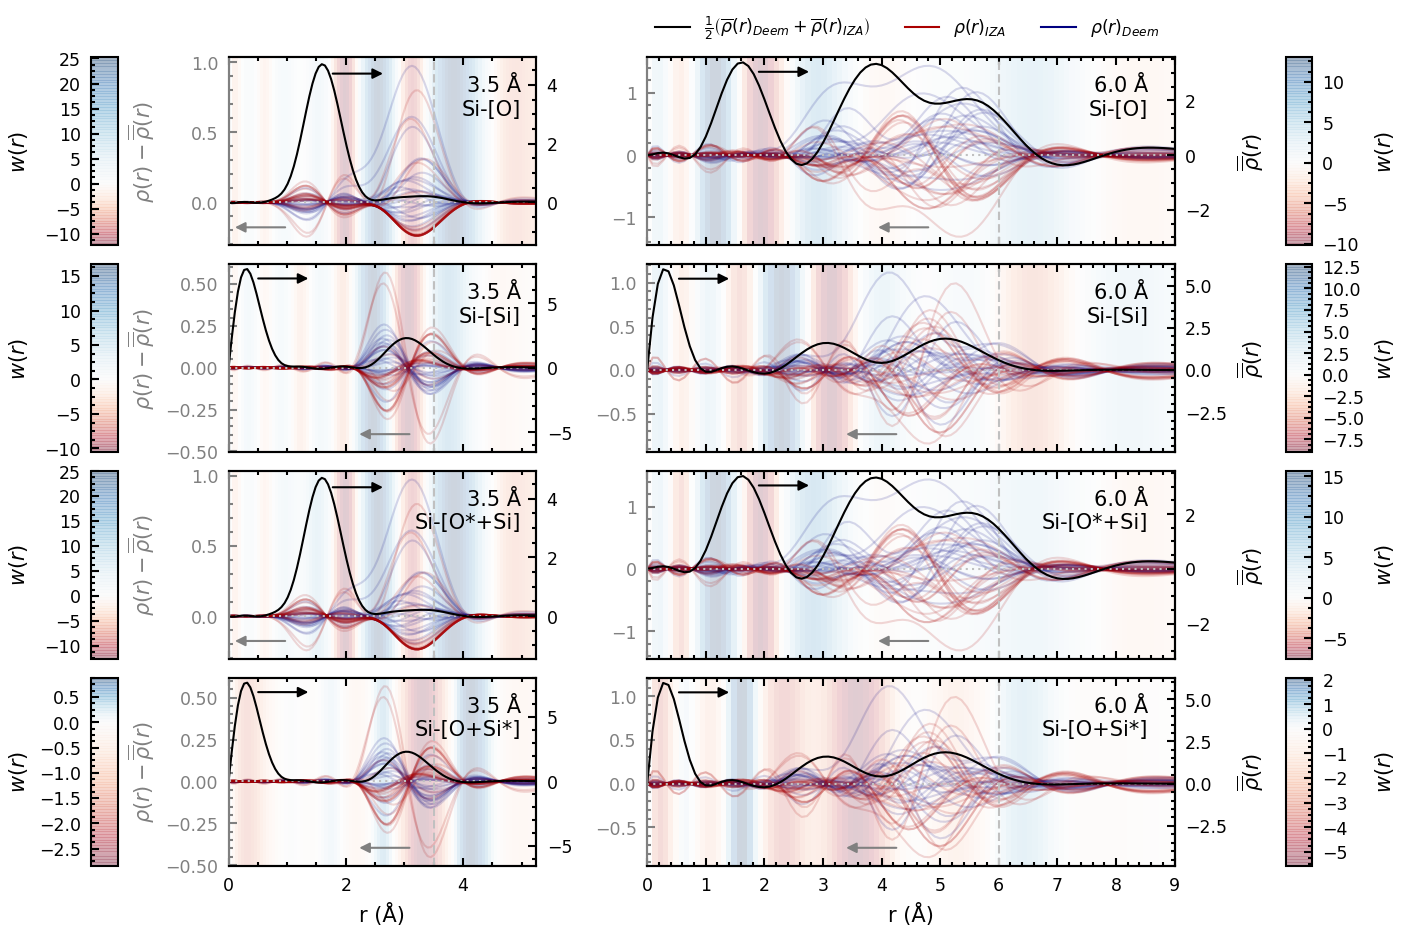

In [62]:
fig = plt.figure(figsize=(10.5, 7.0))
n_cols = 4
n_rows = 4
# n_schematic = 2 * n_cols + 1
max_cutoff = np.amax(cutoffs)
width_ratios = [0.05] + [c / max_cutoff for c in cutoffs] + [0.05]

gs = fig.add_gridspec(
#     nrows=2, ncols=1,
    nrows=n_rows, ncols=n_cols,
#     height_ratios=(0.25, 1.0),
    width_ratios=width_ratios,
    hspace=0.10, wspace=0.50
)

# schematic_gs = gs[0].subgridspec(1, n_schematic)
# data_gs = gs[-1].subgridspec(n_rows, n_cols, width_ratios=width_ratios)
cb_axes = np.array([[fig.add_subplot(gs[i, j]) for j in (0, -1)] for i in range(0, n_rows)])
data_axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(1, n_cols-1)] for i in range(0, n_rows)]) 
# data_axes = np.array([[fig.add_subplot(data_gs[i, j]) for j in range(0, n_cols)] for i in range(0, n_rows)]) 
# schematic_axes = np.array([fig.add_subplot(schematic_gs[i]) for i in range(n_schematic//2-1, n_schematic//2+2)])

data_axes_mean = np.empty((n_rows, 2), dtype='object')

# max_weight = -1.0E10
# min_weight = 1.0E10
# imgs = []

for cdx, cutoff in enumerate(cutoffs):
    linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'
    
    spectrum_type = 'radial'
    spectrum_name = spectrum_type.capitalize()       
     
    plot_idx = 0
    for gdx, group_name in enumerate(group_names[spectrum_type]):

        n_species_plot = group_name.count('+') + 1
        if n_species_plot > 1:
            partial_density_sod = density_sod[cutoff][:]
            partial_density_deem = density_deem_ex[cutoff][:]
            partial_density_iza = density_iza_ex[cutoff][:]
        else:
            partial_density_sod = density_sod[cutoff][:, gdx, :][:, np.newaxis, :]
            partial_density_deem = density_deem_ex[cutoff][:, gdx, :][:, np.newaxis, :]
            partial_density_iza = density_iza_ex[cutoff][:, gdx, :][:, np.newaxis, :]

        n_features = soaps_sod_raw[cutoff].shape[1]

        feature_groups = extract_species_pair_groups(n_features, n_species, 
                                                     spectrum_type=spectrum_type,
                                                     combinations=True)
        
        fdxs = feature_groups[gdx]
                
        # TODO: how to handle multiple decision functions?
        #for n_cantons in (2, 4):
        for n_cantons in [2]:
            
            output = f'../../Results/{cutoff}/real_space_overlap_{n_cantons}-class_{spectrum_type}_{group_name}'

            weights_dir = f'{linear_dir}/{n_cantons}-Class/{spectrum_name}/{group_name}'
            weights_file = f'{weights_dir}/real_space_svc_weights.hdf5'

            hdf5_weights = h5py.File(weights_file, 'r')
            weights = hdf5_weights['0'][:]
            hdf5_weights.close()
            
#             if np.amax(weights) > max_weight:
#                 max_weight = np.amax(weights)
#             if np.amin(weights) < min_weight:
#                 min_weight = np.amin(weights)
            
            full_weights = np.loadtxt(f'{weights_dir}/svc_weights.dat')

            intercept = load_json(f'{weights_dir}/svc.json', array_convert=True)['intercept_'][0]
            dr = np.diff(r_grid[cutoff])[0]

            # Make the radial plot
            group_title = '-'.join(re.findall('[A-Z][a-z]*', group_name))
            species_txt = group_name.split('+')

#             print(np.amin(weights), np.amax(weights))
#             print(f'{cutoff}_{group_name}: {intercept}')
#             for partial_density, soaps in zip((partial_density_sod, partial_density_deem, partial_density_iza),
#                                              (soaps_sod_raw, soaps_deem_ex_raw, soaps_iza_ex_raw)):
#                 print(np.sum(weights * partial_density, axis=(-1, -2)).squeeze() * np.diff(r_grid[cutoff])[0] + intercept)
#                 print(np.sum(weights * partial_density * np.diff(r_grid[cutoff])[0] + intercept/(np.prod(weights.shape[-2:]) - weights.shape[-2]), axis=(-1, -2)).squeeze())
#                 print(np.dot(soaps[cutoff][:, fdxs], full_weights) + intercept)
#                 print('')
            
            for n in range(0, n_species_plot):
                axs = data_axes[plot_idx, cdx]
                pds_min = 1.0E10
                pds_mean = np.mean(np.vstack((np.mean(partial_density_deem[:, n, :], axis=0), np.mean(partial_density_iza[:, n, :], axis=0))), axis=0)
                #yplot_deem = np.mean(partial_density_deem[:, n, :]*weights[:, n, :]*np.diff(r_grid[cutoff])[0]+intercept/len(r_grid[cutoff]), axis=0)
                #yplot_deem = np.mean((partial_density_deem[:, n, :]-pds_mean)*weights[:, n, :]*np.diff(r_grid[cutoff])[0]+intercept/len(r_grid[cutoff]), axis=0)
                #yplot_iza = np.mean(partial_density_iza[:, n, :]*weights[:, n, :]*np.diff(r_grid[cutoff])[0]+intercept/len(r_grid[cutoff]), axis=0)
                #yplot_iza = np.mean((partial_density_iza[:, n, :]-pds_mean)*weights[:, n, :]*np.diff(r_grid[cutoff])[0]+intercept/len(r_grid[cutoff]), axis=0)
                #yplot_mean = np.mean(np.vstack((yplot_deem, yplot_iza)), axis=0)
                for pds in partial_density_deem:
                    #axs.plot(r_grid[cutoff], pds[n], color=color_list[2], alpha=0.05)
                    #axs.plot(r_grid[cutoff], modified_density(pds[n][np.newaxis, np.newaxis, :], weights[:, n, :][:, np.newaxis, :], intercept, dr).squeeze(), color=color_list[2], alpha=0.05)
                    #axs.plot(r_grid[cutoff], modified_weights(weights[:, n, :][:, np.newaxis, :], pds[n][np.newaxis, np.newaxis, :], intercept, dr).squeeze(), color=color_list[2], alpha=0.05)
                    axs.plot(r_grid[cutoff], pds[n]-pds_mean, color=color_list[2], alpha=0.15)
                    #yplot = pds[n]*weights[:, n, :].squeeze()*np.diff(r_grid[cutoff])[0]+intercept/len(r_grid[cutoff])
                    #yplot = (pds[n]-pds_mean)*weights[:, n, :].squeeze()*np.diff(r_grid[cutoff])[0]+intercept/len(r_grid[cutoff])
                    #print(np.sum(yplot))
                    #axs.plot(r_grid[cutoff], yplot-yplot_mean, color=color_list[2], alpha=0.05)
                    #axs.plot(r_grid[cutoff], yplot, color=color_list[2], alpha=0.05)
                    if np.amin(pds[n] - pds_mean) < pds_min:
                        pds_min = np.amin(pds[n] - pds_mean)
                        min_idx = np.argmin(pds[n] - pds_mean)
                        xy_min = np.array([r_grid[cutoff][min_idx], (pds[n] - pds_mean)[min_idx]])

                for pds in partial_density_iza:
                    #axs.plot(r_grid[cutoff], pds[n], color=color_list[1], alpha=0.05)
                    #axs.plot(r_grid[cutoff], modified_density(pds[n][np.newaxis, np.newaxis, :], weights[:, n, :][:, np.newaxis, :], intercept, dr).squeeze(), color=color_list[1], alpha=0.05)
                    #axs.plot(r_grid[cutoff], modified_weights(weights[:, n, :][:, np.newaxis, :], pds[n][np.newaxis, np.newaxis, :], intercept, dr).squeeze(), color=color_list[1], alpha=0.05)
                    axs.plot(r_grid[cutoff], pds[n]-pds_mean, color=color_list[1], alpha=0.15)
                    #yplot = pds[n]*weights[:, n, :].squeeze()*np.diff(r_grid[cutoff])[0]+intercept/len(r_grid[cutoff])
                    #yplot = (pds[n]-pds_mean)*weights[:, n, :].squeeze()*np.diff(r_grid[cutoff])[0]+intercept/len(r_grid[cutoff])
                    #axs.plot(r_grid[cutoff], yplot-yplot_mean, color=color_list[1], alpha=0.05)
                    #axs.plot(r_grid[cutoff], yplot, color=color_list[1], alpha=0.05)
                    if np.amin(pds[n] - pds_mean) < pds_min:
                        pds_min = np.amin(pds[n] - pds_mean)
                        min_idx = np.argmin(pds[n] - pds_mean)
                        xy_min = np.array([r_grid[cutoff][min_idx], (pds[n] - pds_mean)[min_idx]])

                shift = np.array([-0.05, 0.05])
                xy_min = axs.transLimits.transform(xy_min) + shift
                xy_min = axs.transLimits.inverted().transform(xy_min)
                axs.annotate(
                    '',
                    xy=xy_min,
                    xytext=xy_min + np.array([-1.0, 0.0]),
                    xycoords=axs.transData,
                    textcoords=axs.transData,
                    arrowprops=dict(arrowstyle='<|-', color=color_list[5])
                )
                    
                # TODO: replace the Deem and IZA averages with over the whole database (test set only?), not just the
                # random selection
                #axs.plot(
                axs_mean = axs.twinx()
                axs_mean.plot(
                    #r_grid[cutoff], np.mean(partial_density_deem[:, n, :], axis=0), 
                    #r_grid[cutoff], modified_density(np.mean(partial_density_deem[:, n, :], axis=0)[np.newaxis, np.newaxis, :], weights[:, n, :][:, np.newaxis, :], intercept, dr).squeeze(), 
                    #r_grid[cutoff], modified_weights(weights[:, n, :][:, np.newaxis, :], np.mean(partial_density_deem[:, n, :], axis=0)[np.newaxis, np.newaxis, :], intercept, dr).squeeze(), 
                    #r_grid[cutoff], np.mean(partial_density_deem[:, n, :], axis=0)-pds_mean, 
                    #r_grid[cutoff], yplot_deem-yplot_mean, 
                    #r_grid[cutoff], yplot_deem, 
                    r_grid[cutoff], pds_mean, 
                    color=color_list[0]
                )
                axs_mean.set_ylim(align_yaxes(axs_mean, axs, 0.0))
                data_axes_mean[plot_idx, cdx] = axs_mean
                max_idx = np.argmax(pds_mean)
                xy = np.array([r_grid[cutoff][max_idx], pds_mean[max_idx]])
                shift = np.array([0.02, -0.05])
                xy = axs_mean.transLimits.transform(xy) + shift
                xy = axs_mean.transLimits.inverted().transform(xy)
                axs_mean.annotate(
                    '',
                    xy=xy,
                    xytext=xy + np.array([1.0, 0.0]),
                    xycoords=axs_mean.transData,
                    textcoords=axs_mean.transData,
                    arrowprops=dict(arrowstyle='<|-')
                )
                
                #axs.plot(
                    #r_grid[cutoff], np.mean(partial_density_iza[:, n, :], axis=0), 
                    #r_grid[cutoff], modified_density(np.mean(partial_density_iza[:, n, :], axis=0)[np.newaxis, np.newaxis, :], weights[:, n, :][:, np.newaxis, :], intercept, dr).squeeze(),
                    #r_grid[cutoff], modified_weights(weights[:, n, :][:, np.newaxis, :], np.mean(partial_density_iza[:, n, :], axis=0)[np.newaxis, np.newaxis, :], intercept, dr).squeeze(),
                    #r_grid[cutoff], np.mean(partial_density_iza[:, n, :], axis=0)-pds_mean, 
                    #r_grid[cutoff], yplot_iza-yplot_mean, 
                    #r_grid[cutoff], yplot_iza, 
                    #r_grid[cutoff], weights[:, n, :].squeeze(), 
                    #color=color_list[1], label=r'$\mu_{IZA}$'
                #)

                axs.axhline(0.0, linestyle=':', color=color_list[11])
                axs.axvline(cutoff, linestyle='--', color=color_list[11])

#                 axs.plot(r_grid[cutoff], weights[:, n, :].squeeze(), color=color_list[0])

                # Background weights
                extent = [np.amin(r_grid[cutoff]), np.amax(r_grid[cutoff]), *axs.get_ylim()] # left, right, bottom, top 
                w_plot = axs.imshow(
                    weights[:, n, :], extent=extent, aspect='auto', 
                    norm=DivergingNorm(0.0), cmap='RdBu',
                    alpha=0.2,
                    zorder=0
                )
#                 imgs.append(w_plot)
                fig.colorbar(w_plot, cax=cb_axes[plot_idx, cdx], label=r'$w(r)$')
            
                st = species_txt.copy()
                if n_species_plot > 1:
                    st[n] = f'{st[n]}*'
                
                st = '+'.join(st)
                
#                 with plt.rc_context(rc={'text.usetex': True}):
#                     axs.text(
#                         0.95, 0.90, f'{cutoff} ' + u'\u00c5\n' + fr'Si-\textbf{{{st}}}',
#                         horizontalalignment='right', verticalalignment='top',
#                         transform=axs.transAxes
#                     )
                axs.text(
                    0.95, 0.90, f'{cutoff} ' + u'\u00c5\n' + fr'Si-[{st}]',
                    horizontalalignment='right', verticalalignment='top',
                    transform=axs.transAxes
                )
                
                plot_idx += 1
                     
            # Make schematic plot
            # TODO: make weights a background
            # TODO: take this out of the loop
#             labels = [r'$\rho(r)$', r'$w(r)$', r'$\rho(r) w(r)$']
#             if group_name == 'O' and cdx == 1:
#                 pds = partial_density_sod.squeeze()
#                 w = weights.squeeze(axis=1)
                
#                 # Density
#                 schematic_axes[0].plot(r_grid[cutoff], pds, color=color_list[0])
#                 schematic_axes[0].text(
#                     0.95, 0.95, r'$\rho(r)$',
#                     horizontalalignment='right', verticalalignment='top',
#                     transform=schematic_axes[0].transAxes
#                 )
                
#                 # Weights * Density
#                 schematic_axes[2].plot(r_grid[cutoff], pds*w.squeeze(), color=color_list[0])
#                 schematic_axes[2].text(
#                     0.95, 0.95, r'$\rho(r) w(r)$',
#                     horizontalalignment='right', verticalalignment='top',
#                     transform=schematic_axes[2].transAxes
#                 )
                
#                 # Weights (do this after the combined so the y axes limits are correct)
#                 schematic_axes[1].plot(r_grid[cutoff], w.squeeze(), color=color_list[0])
#                 for axs in schematic_axes[1:]:
#                     extent = [np.amin(r_grid[cutoff]), np.amax(r_grid[cutoff]), *axs.get_ylim()] # left, right, bottom, top 
#                     axs.imshow(
#                         w, extent=extent, aspect='auto', 
#                         norm=DivergingNorm(0.0), cmap='RdBu',
#                         alpha=0.2,
#                         zorder=0
#                     )
                
#                 schematic_axes[1].text(
#                     0.95, 0.95, r'$w(r)$',
#                     horizontalalignment='right', verticalalignment='top',
#                     transform=schematic_axes[1].transAxes
#                 )
                    
#                 for axs in schematic_axes:
#                     axs.tick_params(
#                         axis='both', which='both',
#                         left=False, bottom=False, top=False, right=False,
#                         labelleft=False, labelbottom=False, labeltop=False, labelright=False
#                     )
#                     axs.axhline(0.0, color=color_list[11], linestyle=':')

                    
#                 schematic_axes[1].set_ylabel(
#                     r'$\times$', rotation='horizontal', 
#                     horizontalalignment='right', verticalalignment='center'
#                 )
#                 schematic_axes[2].set_ylabel(
#                     r'$=$', rotation='horizontal',
#                     horizontalalignment='right', verticalalignment='center'
#                 )
                        
#                 # Fade the frame
#                 for edge in ['top', 'bottom', 'left', 'right']:
#                     for axs in schematic_axes:
#                         axs.spines[edge].set_color(color_list[11])
 
    
    
for axs in data_axes[:, 0]:
    axs.set_ylabel(r'$\rho(r) - \overline{\overline{\rho}}(r)$', color=color_list[5])

for axs in data_axes[-1, :]:
    axs.set_xlabel('r ' + u'(\u00c5)')
    
for axs in data_axes[0:-1, :].flatten():
    axs.tick_params(labelbottom=False)
    
for axs in data_axes_mean[:, -1]:
    axs.set_ylabel(r'$\overline{\overline{\rho}}(r)$')
    
for axs in data_axes.flatten():
    axs.spines['left'].set_color(color_list[5])
    axs.tick_params(which='both', axis='y', color=color_list[5], labelcolor=color_list[5])
    
# The twinx axis duplicates all spines, so we have to change
# the color here as well
for axs in data_axes_mean.flatten():
    axs.spines['left'].set_color(color_list[5])
    
for caxs in cb_axes[:, 0]:
    caxs.tick_params(which='both', axis='y', right=False, labelright=False, left=True, labelleft=True)
    caxs.yaxis.set_label_position('left')
    
# for img in imgs:
#     img.set_clim(min_weight, max_weight)

legend_elements = [
    Line2D(
        [0], [0], 
        color=color_list[0], 
        label=r'$\frac{1}{2}\left(\overline{\rho}(r)_{Deem} + \overline{\rho}(r)_{IZA}\right)$'
    ),
    Line2D(
        [0], [0], 
        color=color_list[1], 
        label=r'$\rho(r)_{IZA}$'
    ),
    Line2D(
        [0], [0], 
        color=color_list[2], 
        label=r'$\rho(r)_{Deem}$'
    )
]
data_axes[0, -1].legend(
    handles=legend_elements, 
    loc='lower right', bbox_to_anchor=(1.0, 1.0), 
    ncol=3, columnspacing=2.0
)
fig.align_ylabels()
fig.savefig(f'../../Results/real_space_overlap_{n_cantons}-class_{spectrum_type}.pdf', bbox_inches='tight')

plt.show()

In [96]:
11.5/3.5

3.2857142857142856

In [99]:
4*3.285

13.14

6.0-Radial-O: 1.470710355373254
6.0-Power-OO+OSi+SiSi: 1.9480223900691807
3.5-Power-OO+OSi+SiSi: 1.6052968274232846


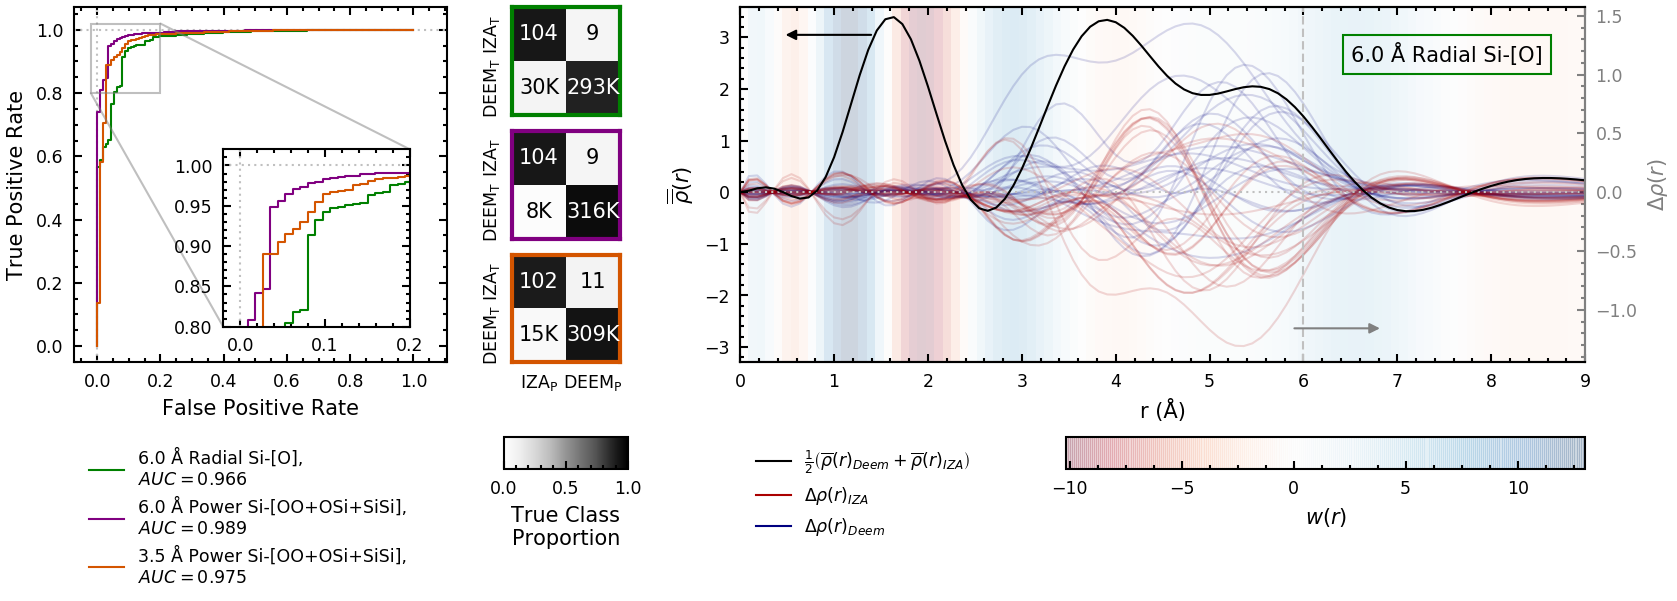

In [118]:
fig = plt.figure(figsize=(13.0, 4.0))

# gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.20)

# density_gs = gs[0].subgridspec(1, 2, width_ratios=(1.0, 0.05), wspace=0.25)
# roc_gs = gs[1].subgridspec(2, 4)

# axs = fig.add_subplot(density_gs[0, 0])
# cb_axs = fig.add_subplot(density_gs[0, 1])

# roc_axs = fig.add_subplot(roc_gs[:, 0:2])
# axs_inset = roc_axs.inset_axes([0.40, 0.10, 0.50, 0.50])
# zoom_x = ([-0.02, 0.20])
# zoom_y = ([0.80, 1.02])
# axs_inset.set_xlim(zoom_x)
# axs_inset.set_ylim(zoom_y)
# roc_axs.indicate_inset_zoom(axs_inset, label=None)

# for ax in (roc_axs, axs_inset):        
#     ax.axvline(0.0, color=color_list[11], linestyle=':')
#     ax.axhline(1.0, color=color_list[11], linestyle=':')

# cm_axes = [fig.add_subplot(roc_gs[i, j]) for i in range(0, 2) for j in range(2, 4)]
# cm_axes[-1].remove()
# cm_cb_gs = roc_gs[-1, -1].subgridspec(1, 3)
# cm_cb_axes = [fig.add_subplot(cm_cb_gs[i]) for i in range(0, 3)]

gs = fig.add_gridspec(
    nrows=5, ncols=5,
#     width_ratios=(1.0, 0.3, 0.2, 1.0, 1.0),
    width_ratios=(1.0, 0.3, 0.2, 0.75, 1.25),
    height_ratios=(1.0, 1.0, 1.0, 0.4, 0.3),
    wspace=0.05
)

axs = fig.add_subplot(gs[0:-2, -2:])
cb_axs = fig.add_subplot(gs[-1, -1])

roc_axs = fig.add_subplot(gs[0:-2, 0])
roc_axs.set_aspect('equal', anchor='NW')
axs_inset = roc_axs.inset_axes([0.40, 0.10, 0.50, 0.50])
zoom_x = ([-0.02, 0.20])
zoom_y = ([0.80, 1.02])
axs_inset.set_xlim(zoom_x)
axs_inset.set_ylim(zoom_y)
roc_axs.indicate_inset_zoom(axs_inset, label=None)

for ax in (roc_axs, axs_inset):        
    ax.axvline(0.0, color=color_list[11], linestyle=':')
    ax.axhline(1.0, color=color_list[11], linestyle=':')

cm_axes = [fig.add_subplot(gs[i, 1]) for i in range(0, 3)]
cm_cb_axs = fig.add_subplot(gs[-1, 1])

# TODO: automatically pull the 'best' species pairings
cutoff_selections = [6.0, 6.0, 3.5]
spectrum_type_selections = ['radial', 'power', 'power']
species_pairing_selections = ['O', 'OO+OSi+SiSi', 'OO+OSi+SiSi', 'O']

# REAL SPACE DENSITY
cutoff = 6.0
linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'    
spectrum_type = 'radial'
spectrum_name = spectrum_type.capitalize()   
group_name = 'O'
n = group_name.count('+')
gdx = group_names[spectrum_type].index(group_name)

partial_density_sod = density_sod[cutoff][:, gdx, :][:, np.newaxis, :]
partial_density_deem = density_deem_ex[cutoff][:, gdx, :][:, np.newaxis, :]
partial_density_iza = density_iza_ex[cutoff][:, gdx, :][:, np.newaxis, :]

n_features = soaps_sod_raw[cutoff].shape[1]

feature_groups = extract_species_pair_groups(
    n_features, n_species, 
    spectrum_type=spectrum_type,
    combinations=True
)

fdxs = feature_groups[gdx]
n_cantons = 2               
            
output = f'../../Results/{cutoff}/real_space_overlap_{n_cantons}-class_{spectrum_type}_{group_name}'

weights_dir = f'{linear_dir}/{n_cantons}-Class/{spectrum_name}/{group_name}'
weights_file = f'{weights_dir}/real_space_svc_weights.hdf5'

hdf5_weights = h5py.File(weights_file, 'r')
weights = hdf5_weights['0'][:]
hdf5_weights.close()

dr = np.diff(r_grid[cutoff])[0]

# Make the radial plot
group_title = '-'.join(re.findall('[A-Z][a-z]*', group_name))
species_txt = group_name.split('+')
   
pds_min = 1.0E10
pds_mean = np.mean(
    np.vstack((
        np.mean(partial_density_deem[:, n, :], axis=0), 
        np.mean(partial_density_iza[:, n, :], axis=0)
    )), 
    axis=0
)

for pds in partial_density_deem:

    axs.plot(r_grid[cutoff], pds[n]-pds_mean, color=color_list[2], alpha=0.15)

    if np.amin(pds[n] - pds_mean) < pds_min:
        pds_min = np.amin(pds[n] - pds_mean)
        min_idx = np.argmin(pds[n] - pds_mean)
        xy_min = np.array([r_grid[cutoff][min_idx], (pds[n] - pds_mean)[min_idx]])

for pds in partial_density_iza:

    axs.plot(r_grid[cutoff], pds[n]-pds_mean, color=color_list[1], alpha=0.15)

    if np.amin(pds[n] - pds_mean) < pds_min:
        pds_min = np.amin(pds[n] - pds_mean)
        min_idx = np.argmin(pds[n] - pds_mean)
        xy_min = np.array([r_grid[cutoff][min_idx], (pds[n] - pds_mean)[min_idx]])

shift = np.array([0.05, 0.05])
xy_min = axs.transLimits.transform(xy_min) + shift
xy_min = axs.transLimits.inverted().transform(xy_min)
axs.annotate(
    '',
    xy=xy_min,
    xytext=xy_min + np.array([1.0, 0.0]),
    xycoords=axs.transData,
    textcoords=axs.transData,
    arrowprops=dict(arrowstyle='<|-', color=color_list[5])
)

# TODO: replace the Deem and IZA averages with over the whole database (test set only?), not just the
# random selection
axs_mean = axs.twinx()
axs_mean.plot(
    r_grid[cutoff], pds_mean, 
    color=color_list[0]
)
axs_mean.set_ylim(align_yaxes(axs_mean, axs, 0.0))
max_idx = np.argmax(pds_mean)
xy = np.array([r_grid[cutoff][max_idx], pds_mean[max_idx]])
shift = np.array([-0.02, -0.05])
xy = axs_mean.transLimits.transform(xy) + shift
xy = axs_mean.transLimits.inverted().transform(xy)
axs_mean.annotate(
    '',
    xy=xy,
    xytext=xy + np.array([-1.0, 0.0]),
    xycoords=axs_mean.transData,
    textcoords=axs_mean.transData,
    arrowprops=dict(arrowstyle='<|-')
)

axs.axhline(0.0, linestyle=':', color=color_list[11])
axs.axvline(cutoff, linestyle='--', color=color_list[11])

# Background weights
extent = [np.amin(r_grid[cutoff]), np.amax(r_grid[cutoff]), *axs.get_ylim()] # left, right, bottom, top 
w_plot = axs.imshow(
    weights[:, n, :], extent=extent, aspect='auto', 
    norm=DivergingNorm(0.0), cmap='RdBu',
    alpha=0.2,
    zorder=0
)
fig.colorbar(w_plot, cax=cb_axs, label=r'$w(r)$', orientation='horizontal')

st = species_txt.copy()
if n > 1:
    st[n] = f'{st[n]}*'

st = '+'.join(st)

axs.text(
    0.95, 0.90, f'{cutoff} ' + u'\u00c5 Radial ' + fr'Si-[{st}]',
    horizontalalignment='right', verticalalignment='top',
    transform=axs.transAxes,
    bbox=dict(edgecolor=color_list[3], fill=False)
)

axs.set_ylabel(r'$\Delta\rho(r)$', color=color_list[5])
axs.set_xlabel('r ' + u'(\u00c5)')

# "Swap" the axes so the mean is on the left, and delta on the right
axs.spines['right'].set_color(color_list[5])
axs.tick_params(
    which='both', axis='y', color=color_list[5], labelcolor=color_list[5],
    left=False, right=True, labelleft=False, labelright=True
)
axs.yaxis.set_label_position('right')

axs_mean.set_ylabel(r'$\overline{\overline{\rho}}(r)$')
axs_mean.yaxis.set_label_position('left')

# The twinx axis duplicates all spines, so we have to change
# the color here as well
axs_mean.spines['right'].set_color(color_list[5])
axs_mean.tick_params(
    which='both', axis='y',
    left=True, right=False, labelleft=True, labelright=False
)

legend_elements = [
    Line2D(
        [0], [0], 
        color=color_list[0], 
        label=r'$\frac{1}{2}\left(\overline{\rho}(r)_{Deem} + \overline{\rho}(r)_{IZA}\right)$'
    ),
    Line2D(
        [0], [0], 
        color=color_list[1], 
        label=r'$\Delta\rho(r)_{IZA}$'
    ),
    Line2D(
        [0], [0], 
        color=color_list[2], 
        label=r'$\Delta\rho(r)_{Deem}$'
    )
]

axs.legend(
    handles=legend_elements, 
    loc='upper left', bbox_to_anchor=(0.0, -0.2), 
)

# ROC CURVES AND CONFUSION MATRICES
roc_cycle = (cycler(color=[color_list[3], color_list[4], color_list[7]]))

vmin = 0.0
vmax = 1.0
cm_norm = Normalize(vmin=vmin, vmax=vmax)

for ax in (roc_axs, axs_inset):
    ax.set_prop_cycle(roc_cycle)

legend_lines = []
for idx, (cutoff, spectrum_type, species_pairing) in enumerate(zip(
    cutoff_selections, spectrum_type_selections, species_pairing_selections
)):
    roc_line_pairs = []
    spectrum_name = spectrum_type.capitalize()
        
    data_dir = f'Linear_Models/LSVC-LPCovR/2-Class/{spectrum_name}/{species_pairing}'

    dfs_iza = \
            np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
    dfs_deem = \
            np.loadtxt(f'{all_deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')

    fpr, tpr, thresholds = roc_curve(
        cantons_test[2], 
        np.concatenate((dfs_iza[idxs_iza_test], dfs_deem)), 
        pos_label=2
    )
    # TODO: micro averaging probably isn't right
    auc = roc_auc_score(
        cantons_test[2],
        np.concatenate((dfs_iza[idxs_iza_test], dfs_deem)),
        average='micro'
    )

    #print(f'{cutoff}-{spectrum_name}-{species_pairing}: {auc}')
    print(f'{cutoff}-{spectrum_name}-{species_pairing}: {-np.log10(1.0-auc)}')

    line_pair = []
    for ax in (roc_axs, axs_inset):
        line = ax.plot(
            fpr, tpr, 
            label=f'{cutoff} ' + u'\u00c5 ' + f'{spectrum_name} Si-[{species_pairing}],\n$AUC={{{auc:0.3f}}}$'
        )
        line_pair.extend(line)
    roc_line_pairs.append(line_pair)
    
    for line_pair in roc_line_pairs:
        legend_lines.append(line_pair[0])
        
    #axs[cutoff].set_xlim([-0.01, 0.2])
    roc_axs.set_ylabel('True Positive Rate')
    roc_axs.set_xlabel('False Positive Rate')
    
    # CONFUSION MATRIX  
    predicted_cantons_iza = \
        np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)

    predicted_cantons_deem = \
        np.loadtxt(f'{all_deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
        
    predicted_cantons_test = np.concatenate((
        predicted_cantons_iza[idxs_iza_test], 
        np.delete(predicted_cantons_deem, idxs_deem_10k[idxs_deem_train])
    ))
    
    matrix_test = confusion_matrix(
#         cantons_test[2], 
        np.delete(cantons_test[2], idxs_deem_10k[idxs_deem_train] + len(idxs_iza_test)),
        predicted_cantons_test
    )

    matrix_ref = np.zeros((2, 2), dtype=int)
    for i in range(0, 2):
        matrix_ref[i, i] = np.count_nonzero(cantons_test[2] == (i + 1))

    matrix_norm = matrix_test / np.diagonal(matrix_ref)[:, np.newaxis]

#     cmap_colors = ('#ffffff', line[0].get_color())
#     cmap = LinearSegmentedColormap.from_list(f'cmap_{idx}', cmap_colors)
    mat_axs = cm_axes[idx]
#     cm_cb_axs = cm_cb_axes[idx]
#     vmin = 0.0
#     vmax = 1.0
    matshow = mat_axs.imshow(matrix_norm, cmap='Greys', norm=cm_norm)
#     cm_cb = fig.colorbar(matshow, cax=cm_cb_axs)
#     if idx == 2:
#         cm_cb.set_label('True Class Proportion')
        
    for spine in mat_axs.spines.values():
        spine.set_color(line[0].get_color())
        spine.set_linewidth(2.0)

#     text_size = 'medium'

    for i in range(0, 2):
        for j in range(0, 2):
            if matrix_norm[i, j] > (0.5 * vmax):
                text_color = 'w'
            else:
                text_color = 'k'

            if len(str(matrix_test[i, j])) > 3:

                # This isn't a very 'robust' way of doing this,
                # but since we only go up to 6 digits, this should work
                # (we do this shortening only if the number has 6 digits)
                box_number_str = str(round(matrix_test[i, j], -3))
                box_number_str = box_number_str[0:-3] + 'K'
            else:
                box_number_str = f'{matrix_test[i, j]:d}'

            mat_axs.text(
                j, i, box_number_str,
                horizontalalignment='center', verticalalignment='center',
                color=text_color, #fontsize=text_size
            )

    mat_axs.set_xticks(np.arange(0, 2))
    mat_axs.set_yticks(np.arange(0, 2))

#     if idx < 2:
    if idx == 2:
        mat_axs.set_xticklabels([tl + r'$_\mathrm{P}$' for tl in ticklabels[2]])
        mat_axs.tick_params(
            axis='x', which='both',
            bottom=False, top=False,
            labelbottom=True, labeltop=False
        )
    else:
        mat_axs.tick_params(
            axis='x', which='both',
            bottom=False, top=False,
            labelbottom=False, labeltop=False
        )

#     if idx != 1:
    mat_axs.set_yticklabels([tl + r'$_\mathrm{T}$' for tl in ticklabels[2]], rotation=90, verticalalignment='center')
    mat_axs.tick_params(
        axis='y', which='both',
        left=False, right=False,
        labelleft=True, labelright=False
    )
#     else:
#         mat_axs.tick_params(
#             axis='y', which='both',
#             left=False, right=False,
#             labelleft=False, labelright=False
#         )

sm = ScalarMappable(norm=cm_norm, cmap='Greys')
cm_cb = fig.colorbar(sm, cax=cm_cb_axs, orientation='horizontal')
cm_cb.set_label('True Class\nProportion')
    
roc_axs.legend(loc='upper left', bbox_to_anchor=(0.0, -0.2))
    
for ax in cm_cb_axes[0:2]:
    ax.tick_params(which='both', axis='y', labelright=False)

fig.align_ylabels()
fig.savefig(f'../../Results/real_space_density_summary.svg', bbox_inches='tight')

plt.show()

In [55]:
x = np.arange(10)
nd = x.ndim
print(np.prod(x.shape[-(nd-1):]) - x.shape[-(nd-1)])

0


In [41]:
def modified_weights(w, x, b, dr):
    """
        Construct modified weights that account for the SVM bias (intercept)
        This one works!
    """
    
    ndim = w.ndim
    n = np.prod(w.shape[-(ndim - 1):]) - w.shape[-(ndim - 1)] # Why this?
    bb = np.zeros(x.shape)
    d = x[x != 0.0] * n * dr
    bb[x != 0.0] = b / d
    #bb[x == 0.0] = b / (n * dr)
    return w + bb

def modified_weights2(w, x, b, dr):
    """
        Construct modified weights that account for the SVM bias (intercept)
    """
    
    n = np.prod(w.shape[-2:]) - w.shape[-2]
    bb = np.zeros(x.shape)
    d = x[x != 0.0] * n
    bb[x != 0.0] = b / d
    #bb[x == 0.0] = b / n
    return w*dr + bb

def modified_weights3(w, x, b, dr):
    """
        Construct modified weights that account for the SVM bias (intercept)
    """
    
    rb = np.random.rand(*w.shape)
    rb = b * rb / np.sum(rb)
    rb = np.tile(rb, (x.shape[0], 1, 1))
    bb = np.zeros(x.shape)
    d = x[x != 0.0] * dr
    bb[x != 0.0] = rb[x != 0.0] / d
    #bb[x == 0.0] = b / (n * dr)
    return w + bb

def modified_weights4(w, x, b, dr):
    """
        Construct modified weights that account for the SVM bias (intercept)
    """
    
    rb = w.copy()
    rb = b * rb / np.sum(rb)
    rb = np.tile(rb, (x.shape[0], 1, 1))
    bb = np.zeros(x.shape)
    d = x[x != 0.0] * dr
    bb[x != 0.0] = rb[x != 0.0] / d
    #bb[x == 0.0] = b / (n * dr)
    return w + bb

def modified_density(x, w, b, dr):
    """
        Construct modified density that accounts for the SVM bias (intercept)
        This one works!
    """
    
    ndim = w.ndim
    n = np.prod(w.shape[-(ndim - 1):]) - w.shape[-(ndim - 1)] # Why this?
    bb = np.zeros(w.shape)
    d = w[w != 0.0] * n * dr
    bb[w != 0.0] = b / d
    #bb[w == 0.0] = b / (n * dr)
    return x + bb

def modified_density2(x, w, b, dr):
    """
        Construct modified density that accounts for the SVM bias (intercept)
    """
    
    n = np.prod(w.shape[-2:]) - w.shape[-2]
    bb = np.zeros(w.shape)
    d = w[w != 0.0] * n
    bb[w != 0.0] = b / d
    #bb[w == 0.0] = b / n
    return x*dr + bb

In [42]:
dr = np.diff(r_grid[cutoff])[0]
df = np.sum(weights[0, 0, :][np.newaxis, np.newaxis, :] * partial_density_deem[0, 0, :][np.newaxis, np.newaxis, :], axis=(-2, -1)).squeeze() * dr + intercept
df_mod = np.sum(modified_weights(weights[0, 0, :][np.newaxis, np.newaxis, :], partial_density_deem[0, 0, :][np.newaxis, np.newaxis, :], intercept, dr) * partial_density_deem[0, 0, :][np.newaxis, np.newaxis, :], axis=(-2, -1)) * dr
df_mod2 = np.sum(modified_weights2(weights[0, 0, :][np.newaxis, np.newaxis, :], partial_density_deem[0, 0, :][np.newaxis, np.newaxis, :], intercept, dr) * partial_density_deem[0, 0, :][np.newaxis, np.newaxis, :], axis=(-2, -1))
df_mod3 = np.sum(modified_weights3(weights[0, 0, :][np.newaxis, np.newaxis, :], partial_density_deem[0, 0, :][np.newaxis, np.newaxis, :], intercept, dr) * partial_density_deem[0, 0, :][np.newaxis, np.newaxis, :], axis=(-2, -1)) * dr
df_mod4 = np.sum(modified_weights4(weights[0, 0, :][np.newaxis, np.newaxis, :], partial_density_deem[0, 0, :][np.newaxis, np.newaxis, :], intercept, dr) * partial_density_deem[0, 0, :][np.newaxis, np.newaxis, :], axis=(-2, -1)) * dr
print(df)
print(df_mod)
print(df_mod2)
print(df_mod3)
print(df_mod4)
print(df_mod3 - df)
print(intercept)

14.739588648849121
[14.73958865]
[14.73958865]
[14.74358474]
[14.73958865]
[0.00399609]
-0.35636247906969476


In [43]:
dr = np.diff(r_grid[cutoff])[0]
df = np.sum(weights * partial_density_deem, axis=(-2, -1)).squeeze() * dr + intercept
df_mod = np.sum(modified_weights(weights, partial_density_deem, intercept, dr) * partial_density_deem, axis=(-2, -1)) * dr
df_mod2 = np.sum(modified_weights2(weights, partial_density_deem, intercept, dr) * partial_density_deem, axis=(-2, -1))
df_mod3 = np.sum(modified_weights3(weights, partial_density_deem, intercept, dr) * partial_density_deem, axis=(-2, -1)) * dr
df_mod4 = np.sum(modified_weights4(weights, partial_density_deem, intercept, dr) * partial_density_deem, axis=(-2, -1)) * dr
print(df)
print(df_mod)
print(df_mod2)
print(df_mod3)
print(df_mod4)
print(df_mod3 - df)
print(intercept)

[ 1.11613067  0.32482326  0.75702346  2.35002787 -0.46565534  2.55921744
  0.99600192  1.63766419  0.51285976  2.01258916  0.848512    1.23708354
  1.46749138  0.90965612  3.01729496 -0.42121494  4.579907    2.16095283
  1.59230747  1.24115303  1.20138794  1.78213563  1.49480729 -0.45978999
  2.2983965   0.93225138  2.67605512  2.92789778  0.70505266  0.38967076
  0.83733125  0.47913018  2.24250818  1.39759089 -0.07156553  0.72492914
  1.81895205  2.36807783  2.75460697  0.64198869  1.78848618  1.04265591
  4.78051129  3.11218239  2.43108761  1.53028085  1.29117041  1.75720296
  1.63411297  0.66046528]
[ 1.11613067  0.32482326  0.75702346  2.35002787 -0.46565534  2.55921744
  0.99600192  1.63766419  0.51285976  2.01258916  0.848512    1.23708354
  1.46749138  0.90965612  3.01729496 -0.42121494  4.579907    2.16095283
  1.59230747  1.24115303  1.20138794  1.78213563  1.49480729 -0.45978999
  2.2983965   0.93225138  2.67605512  2.92789778  0.70505266  0.38967076
  0.83733125  0.47913018 

In [31]:
dr = np.diff(r_grid[cutoff])[0]
df = np.sum(weights * partial_density_deem, axis=(-2, -1)).squeeze() * dr + intercept
df_mod = np.sum(weights * modified_density(partial_density_deem, weights, intercept, dr), axis=(-2, -1)) * dr
df_mod2 = np.sum(weights * modified_density2(partial_density_deem, weights, intercept, dr), axis=(-2, -1))
print(df)
print(df_mod)
print(df_mod2)

[ 1.11613067  0.32482326  0.75702346  2.35002787 -0.46565534  2.55921744
  0.99600192  1.63766419  0.51285976  2.01258916  0.848512    1.23708354
  1.46749138  0.90965612  3.01729496 -0.42121494  4.579907    2.16095283
  1.59230747  1.24115303  1.20138794  1.78213563  1.49480729 -0.45978999
  2.2983965   0.93225138  2.67605512  2.92789778  0.70505266  0.38967076
  0.83733125  0.47913018  2.24250818  1.39759089 -0.07156553  0.72492914
  1.81895205  2.36807783  2.75460697  0.64198869  1.78848618  1.04265591
  4.78051129  3.11218239  2.43108761  1.53028085  1.29117041  1.75720296
  1.63411297  0.66046528]
[ 1.11613067  0.32482326  0.75702346  2.35002787 -0.46565534  2.55921744
  0.99600192  1.63766419  0.51285976  2.01258916  0.848512    1.23708354
  1.46749138  0.90965612  3.01729496 -0.42121494  4.579907    2.16095283
  1.59230747  1.24115303  1.20138794  1.78213563  1.49480729 -0.45978999
  2.2983965   0.93225138  2.67605512  2.92789778  0.70505266  0.38967076
  0.83733125  0.47913018 

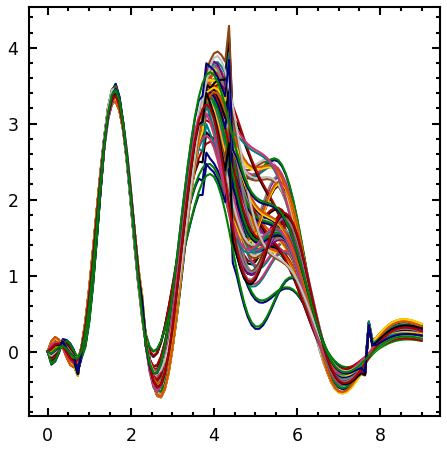

In [32]:
for n in range(0, 50):
    plt.plot(r_grid[cutoff], modified_density(partial_density_iza[n, 0, :][np.newaxis, np.newaxis, :], weights[0, 0, :][np.newaxis, np.newaxis, :], intercept, dr).squeeze())
    plt.plot(r_grid[cutoff], partial_density_iza[n, 0, :])
plt.show()

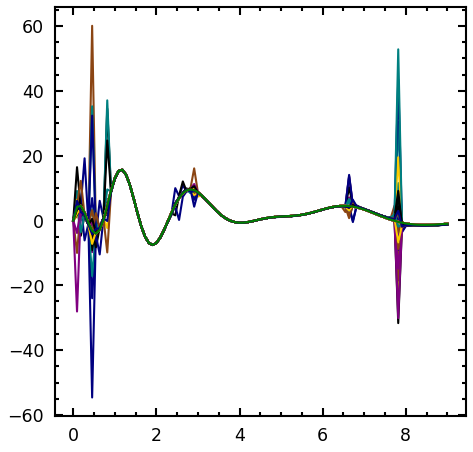

In [46]:
for n in range(0, 50):
    plt.plot(r_grid[cutoff], modified_weights(weights[0, 0, :][np.newaxis, np.newaxis, :], partial_density_iza[n, 0, :][np.newaxis, np.newaxis, :], intercept, dr).squeeze())
    plt.plot(r_grid[cutoff], weights[0, 0, :])
plt.show()

# Plot basis functions

In [ ]:
from soap import gto_sigma, gto_overlap, gto
from scipy.linalg import fractional_matrix_power

In [ ]:
R_n = {}
for cutoff in cutoffs:
    
    # Setup grids of the expansion orders
    n_grid = np.arange(0, soap_hyperparameters['max_radial'])
    sigma_grid = gto_sigma(cutoff, n_grid, soap_hyperparameters['max_radial'])

    # Compute radial normalization factor based on the GTO overlap
    S = gto_overlap(n_grid[:, np.newaxis],
                    n_grid[np.newaxis, :],
                    sigma_grid[:, np.newaxis],
                    sigma_grid[np.newaxis, :])
    S = fractional_matrix_power(S, -0.5)

    # Compute GTOs, shape (n_max, len(r_grid))
    R_n[cutoff] = np.matmul(S, gto(r_grid[cutoff][np.newaxis, :],
                            n_grid[:, np.newaxis],
                            sigma_grid[:, np.newaxis]))

In [ ]:
for cutoff in cutoffs:
    fig = plt.figure(figsize=(3.5, 3.5))
    axs = fig.add_subplot(1, 1, 1)
    
    for rdx, r_n in enumerate(R_n[cutoff]):
        axs.plot(r_grid[cutoff], r_n, label=f'n = {rdx+1}')
        axs.axvline(cutoff, linestyle='--', color=color_list[9])
        
plt.show()